In [23]:
# 节点嵌入

In [24]:
import networkx as nx

import torch
import torch.nn as nn
from torch.optim import SGD

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import random


In [25]:
G = nx.karate_club_graph()
print(type(G))


<class 'networkx.classes.graph.Graph'>


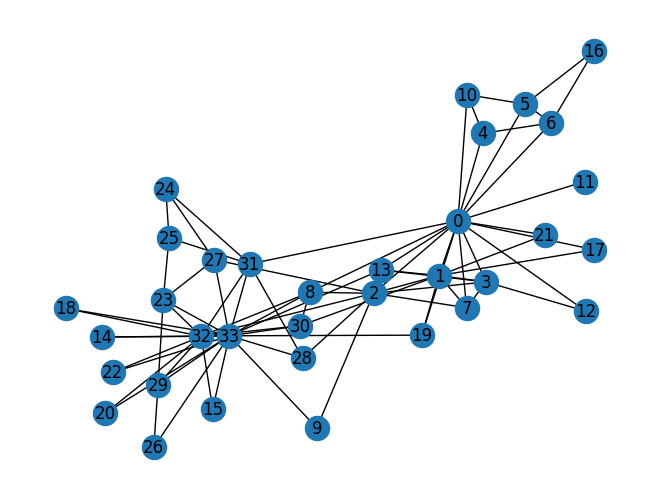

In [26]:
nx.draw(G, with_labels=True)


In [27]:
# every_degree
num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degreee = round(2*num_edges/num_nodes)

In [28]:
# 聚类系数
avg_cluster_coef = round(nx.average_clustering(G), 2)


In [29]:
# pagerank
beta = 0.8

r0 = 1 / G.number_of_nodes()
r1 = 0
# 得到node0的邻居
# 得到这些邻居的出度（是无向图，所以就是度数）
# 计算得到右式中的第一项（\sum{i→j}\beta\frac{r_i}{d_i}）
# 计算得到r_j
for ni in nx.neighbors(G, 0):
    # 得到的每一个ni都是node0邻居的索引
    di = G.degree[ni]  # 获取node_ni的度数
    r1 += beta * r0 / di
r1 += (1 - beta) * (1 / G.number_of_nodes())
r1 = round(r1, 2)


In [30]:
closeness = nx.closeness_centrality(G, u=5)
closeness = closeness / (G.number_of_nodes() - 1)
closeness = round(closeness, 2)


In [31]:
# 神经网络
def graph_to_edge_list(G):
    edge_list = []
    for edge in G.edges():
        edge_list.append(edge)
    return edge_list


def edge_list_to_tensor(edge_list):
    edge_index = torch.LongTensor(edge_list).t()
    return edge_index


pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)  # 作为正
print(pos_edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  4,
          4,  5,  5,  5,  6,  8,  8,  8,  9, 13, 14, 14, 15, 15, 18, 18, 19, 20,
         20, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 26, 26, 27, 28, 28, 29,
         29, 30, 30, 31, 31, 32],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  2,  3,
          7, 13, 17, 19, 21, 30,  3,  7,  8,  9, 13, 27, 28, 32,  7, 12, 13,  6,
         10,  6, 10, 16, 16, 30, 32, 33, 33, 33, 32, 33, 32, 33, 32, 33, 33, 32,
         33, 32, 33, 25, 27, 29, 32, 33, 25, 27, 31, 31, 29, 33, 33, 31, 33, 32,
         33, 32, 33, 32, 33, 33]])


In [32]:
def sample_negative_edges(G, num_neg_samples):
    # 题目要求：不用考虑num_neg_samples比所有不存在边的数量还高的边界条件
    # 不考虑自环
    # 注意，本来需要考虑逆边的问题，但是由于我采用的nx.non_edges函数不会出现两次重复节点对，所以不用考虑这个问题。

    neg_edge_list = []

    # 得到图中所有不存在的边（这个函数只会返回一侧，不会出现逆边）
    non_edges_one_side = list(enumerate(nx.non_edges(G)))
    neg_edge_list_indices = random.sample(
        range(0, len(non_edges_one_side)), num_neg_samples
    )
    # 取样num_neg_samples长度的索引
    for i in neg_edge_list_indices:
        neg_edge_list.append(non_edges_one_side[i][1])

    return neg_edge_list


# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

############# Your code here ############
# 如果边在图中，就认为不行
print(
    "edge_1"
    + (" can't" if G.has_edge(edge_1[0], edge_1[1]) else " can")
    + " be negative edge"
)
print(
    "edge_2"
    + (" can't" if G.has_edge(edge_2[0], edge_2[1]) else " can")
    + " be negative edge"
)
print(
    "edge_3"
    + (" can't" if G.has_edge(edge_3[0], edge_3[1]) else " can")
    + " be negative edge"
)
print(
    "edge_4"
    + (" can't" if G.has_edge(edge_4[0], edge_4[1]) else " can")
    + " be negative edge"
)
print(
    "edge_5"
    + (" can't" if G.has_edge(edge_5[0], edge_5[1]) else " can")
    + " be negative edge"
)
#########################################


edge_1 can't be negative edge
edge_2 can be negative edge
edge_3 can't be negative edge
edge_4 can't be negative edge
edge_5 can be negative edge


In [33]:
torch.manual_seed(1)


def create_node_emb(num_node=34, embedding_dim=16):
    # 题目要求：用均匀分布初始化Embedding
    # 其实我看了下文档，Embedding初始化本来就是均匀分布。不过在这里应该是要用manual_seed来维持可复现性
    emb = nn.Embedding(num_node, embedding_dim)
    emb.weight.data = torch.rand(num_node, embedding_dim)
    return emb


emb = create_node_emb()


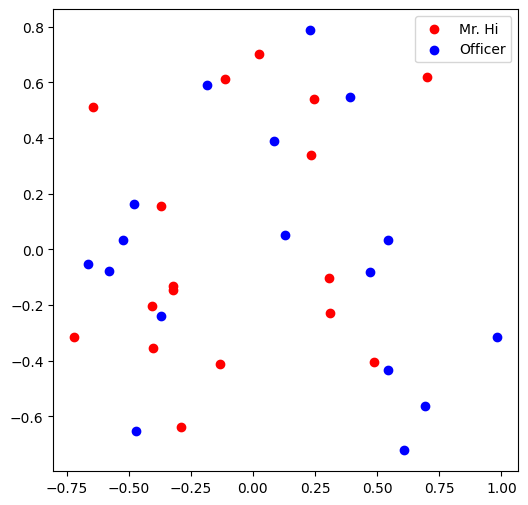

In [34]:
def visualize_emb(emb):
    X = emb.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    plt.figure(figsize=(6, 6))
    club1_x = []
    club1_y = []
    club2_x = []
    club2_y = []
    for node in G.nodes(data=True):
        if node[1]["club"] == "Mr. Hi":
            # node的形式：第一个元素是索引，第二个元素是attributes字典
            club1_x.append(components[node[0]][0])
            club1_y.append(components[node[0]][1])
            # 这里添加的元素就是节点对应的embedding经PCA后的两个维度
        else:
            club2_x.append(components[node[0]][0])
            club2_y.append(components[node[0]][1])
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
    plt.scatter(club2_x, club2_y, color="blue", label="Officer")
    plt.legend()
    plt.show()


# Visualize the initial random embeddding
visualize_emb(emb)


In [35]:
pos_label = torch.ones(pos_edge_index.shape[1],)
neg_label = torch.zeros(neg_edge_index.shape[1],)
label = torch.cat([pos_label, neg_label], dim=0)
print(pos_edge_index.shape)
edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(edge.shape)

torch.Size([2, 78])
torch.Size([2, 156])


In [37]:
import torch.nn as nn
from typing import Optional
def accuracy(pred, label):
    # 题目要求：
    # 输入参数：
    #  pred (the resulting tensor after sigmoid)
    #  label (torch.LongTensor)
    # 预测值大于0.5被分类为1，否则就为0
    # 准确率返回值保留4位小数

    # accuracy=预测与实际一致的结果数/所有结果数
    # pred和label都是[78*2=156]大小的Tensor
    accu = round(((pred > 0.5) == label).sum().item() / (pred.shape[0]), 4)
    return accu

class Trainer:
    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        data: list[torch.Tensor, torch.Tensor],
        gpu_id: int = -1,
        save_every: int = 10,
    ):
        self.model = model
        self.optimizer = optimizer
        self.gpu_id = gpu_id
        self.save_every = save_every
        self.data = data
        self.model = self.model.to(self.gpu_id)
    
    def _run_epoch(self, epoch):
        train_edge, train_label = self.data
        train_edge = train_edge.to(self.gpu_id)
        train_label = train_label.to(self.gpu_id)
        train_node_emb = self.model(train_edge)
        dot_product_result = train_node_emb[0].mul(train_node_emb[1])
        dot_product_result = torch.sum(
            dot_product_result, 1
        )
        sigmoid_result = torch.sigmoid(
            dot_product_result
        )
        loss_fn = nn.BCELoss()
        loss_result = loss_fn(sigmoid_result, train_label)
        self.optimizer.zero_grad()
        loss_result.backward()
        self.optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss {loss_result}")
            print(accuracy(sigmoid_result, train_label))
        
    def train(self, max_epoch):
        for epoch in range(max_epoch):
            self._run_epoch(epoch)
            if epoch % self.save_every == 0:
                torch.save(self.model.state_dict(), f"model_{epoch}.pth")
                

In [40]:
class Embedding_Model(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(Embedding_Model, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        emb.weight.data = torch.rand(num_nodes, embedding_dim)
    
    def forward(self, edge):
        return self.embedding(edge)

model = Embedding_Model(num_nodes, 16)
optimizer = SGD(model.parameters(), lr=0.01)
trainer = Trainer(model, optimizer, [edge, label], gpu_id=0, save_every=100)
trainer.train(500)

Epoch 0 | Loss 1.6790895462036133
0.4551
Epoch 10 | Loss 1.6697139739990234
0.4551
Epoch 20 | Loss 1.6604021787643433
0.4551
Epoch 30 | Loss 1.6511539220809937
0.4551
Epoch 40 | Loss 1.6419613361358643
0.4551
Epoch 50 | Loss 1.6328243017196655
0.4551
Epoch 60 | Loss 1.6237502098083496
0.4615
Epoch 70 | Loss 1.6147377490997314
0.4615
Epoch 80 | Loss 1.6057802438735962
0.4615
Epoch 90 | Loss 1.5968774557113647
0.4615
Epoch 100 | Loss 1.5880355834960938
0.4615
Epoch 110 | Loss 1.5792485475540161
0.4679
Epoch 120 | Loss 1.5705212354660034
0.4679
Epoch 130 | Loss 1.5618478059768677
0.4744
Epoch 140 | Loss 1.553228497505188
0.4808
Epoch 150 | Loss 1.5446683168411255
0.4808
Epoch 160 | Loss 1.5361614227294922
0.4808
Epoch 170 | Loss 1.5277125835418701
0.4808
Epoch 180 | Loss 1.519311785697937
0.4936
Epoch 190 | Loss 1.5109738111495972
0.4936
Epoch 200 | Loss 1.502683162689209
0.4936
Epoch 210 | Loss 1.4944496154785156
0.4936
Epoch 220 | Loss 1.486268401145935
0.4936
Epoch 230 | Loss 1.4781407

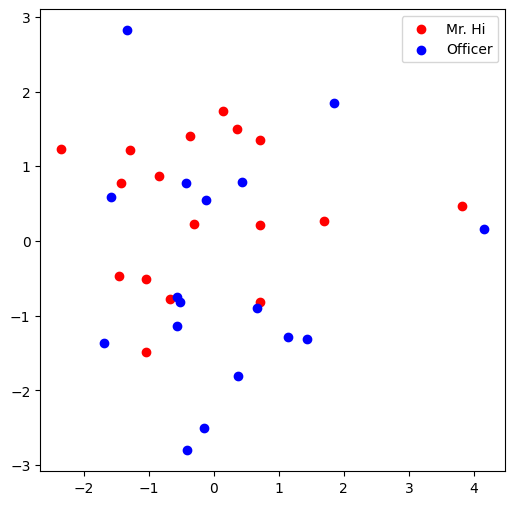

In [45]:
visualize_emb(model.embedding.cpu())